# Coursera course work

Q: In this project you will use the tools and techniques you learned throughout this course to train a few classification models on a data set that you feel passionate about, select the regression that best suits your needs, and communicate insights you found from your modeling exercise.
After going through some guided steps, you will have insights that either explain or predict your outcome variable. As a main deliverable, you will submit a report that helps you focus on highlighting your analytical skills and thought process. 

I have chosen the **iris** dataset in sklearn which descirbed iris flours and try to predict the species based on the provided features. The sections will include the followings:
* Load and Inspect Data
* Train Test Split and Define Accuracy Metrics
* Decision Tree
* Random Forest
* Gradient Boost
* Summary


# Objectives


 Iris dataset is one of the best known dataset to practice pattern recognition. It is recorded in Fisher's paper and it is still  referenced frequently to this day. (See Duda & Hart, for example.) This dataset contains 3 classes of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the other 2; the latter are NOT linearly separable from each other. **Our objective is to build a model to predict the species of iris based on the given features, sepal length, sepal width, petal length and petal width in centimeters.** The model should be interpretable and provide inisight to this dataset. 

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [43]:
from xgboost import XGBClassifier

In [2]:
# import packages and basic settings
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
import itertools
import os
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance, plot_partial_dependence

# Evaluation metrics related methods
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score, confusion_matrix

pd.set_option('display.expand_frame_repr', False)

## Load and Inspect Data
### Load Iris dataset

In [3]:
iris_dataset = datasets.load_iris()
df_iris = pd.DataFrame(data=iris_dataset.data, 
                       columns = iris_dataset.feature_names,
                       dtype =np.float32,
                       copy = False
                       )
df_iris['species'] = iris_dataset.target_names[iris_dataset.target]

### Basic Inspection

In [4]:
print('data frame samples')
print(tabulate(df_iris.sample(n=5), headers = 'keys', tablefmt = 'plain'))
print(f'\ndata shape = {df_iris.shape[1]} columns x {df_iris.shape[0]} rows')
print(f'\ncolumns: {df_iris.columns.to_list()}')
print(tabulate(df_iris.dtypes.reset_index(), headers = 'keys', tablefmt = 'plain'))

data frame samples
      sepal length (cm)    sepal width (cm)    petal length (cm)    petal width (cm)  species
57                  4.9                 2.4                  3.3                 1    versicolor
70                  5.9                 3.2                  4.8                 1.8  versicolor
31                  5.4                 3.4                  1.5                 0.4  setosa
39                  5.1                 3.4                  1.5                 0.2  setosa
19                  5.1                 3.8                  1.5                 0.3  setosa

data shape = 5 columns x 150 rows

columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'species']
    index              0
 0  sepal length (cm)  float32
 1  sepal width (cm)   float32
 2  petal length (cm)  float32
 3  petal width (cm)   float32
 4  species            object


In [5]:
# rename columns
print('non-standard column names')
df_iris.columns = [col.replace(' (cm)', '').replace(' ', '_') for col in df_iris.columns]
print(f'new columns: {df_iris.columns.to_list()}')

non-standard column names
new columns: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']


In [6]:
# basic statistical inspection
print('data count per category')
print(df_iris.species.value_counts())
df_stats = df_iris.describe()
df_stats.loc['range'] = df_stats.loc['max'] - df_stats.loc['min']
out_fields = ['mean','25%','50%','75%','range']
df_stats.rename({'50%':'median'},inplace=True)
print(tabulate(df_stats,headers='keys',tablefmt='plain'))

data count per category
setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64
          sepal_length    sepal_width    petal_length    petal_width
count       150            150               150          150
mean          5.84333        3.05733           3.758        1.19933
std           0.828066       0.435866          1.7653       0.762238
min           4.3            2                 1            0.1
25%           5.1            2.8               1.6          0.3
median        5.8            3                 4.35         1.3
75%           6.4            3.3               5.1          1.8
max           7.9            4.4               6.9          2.5
range         3.6            2.4               5.9          2.4


### key summaries 
* 4 numerical features
* predict categorical data
* 150 records
* no data missing
* no imbalance data

## Train Test Split and Define Accuracy Merics

In [7]:
seed = 123

In [8]:
X = df_iris.iloc[:,:-1]
y = df_iris.iloc[:,-1:]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify =y, test_size = 0.2, random_state= seed)

In [10]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='macro')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Summary 
* splitted into Train with 120 data samples, and Test with 30 data samples in stratefied manner
* employed f1 macro as the accuracy check
* defined confussion matrix as visualization

## Decision Tree
### Train Model

In [12]:
params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5, 6, 7, 8]
}

In [13]:
DT = DecisionTreeClassifier(random_state=seed)

grid_search = GridSearchCV(estimator = DT, 
                        param_grid = params_grid, 
                        scoring='f1_macro',
                        cv = 4, verbose = 1)
grid_search.fit(X_train, y_train.values.ravel())
best_params = grid_search.best_params_

Fitting 4 folds for each of 72 candidates, totalling 288 fits


In [14]:
grid_search.best_score_

0.9581023265233791

In [15]:
DT_best = DecisionTreeClassifier(random_state=seed, **best_params)
DT_best.fit(X_train,y_train)
y_p_DT = DT_best.predict(X_test)
print(f'model f1 macro score: {DT_best.score(X_train, y_train)}')

model f1 macro score: 0.9666666666666667


In [16]:
evaluate_metrics(y_test, y_p_DT)

{'accuracy': 0.9,
 'recall': 0.9,
 'precision': 0.923076923076923,
 'f1score': 0.8976982097186701}

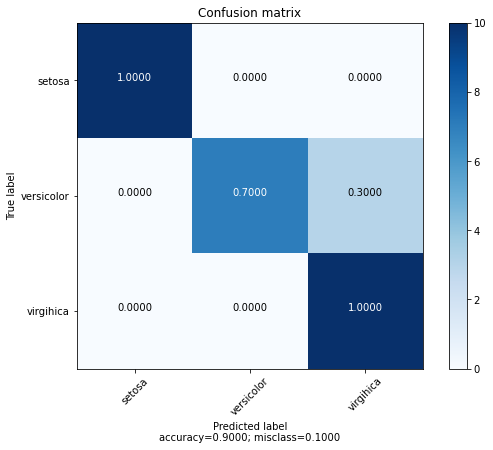

In [17]:
plot_confusion_matrix(confusion_matrix(y_test, y_p_DT),
                          ['setosa','versicolor','virgihica'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)

### Interpret Model

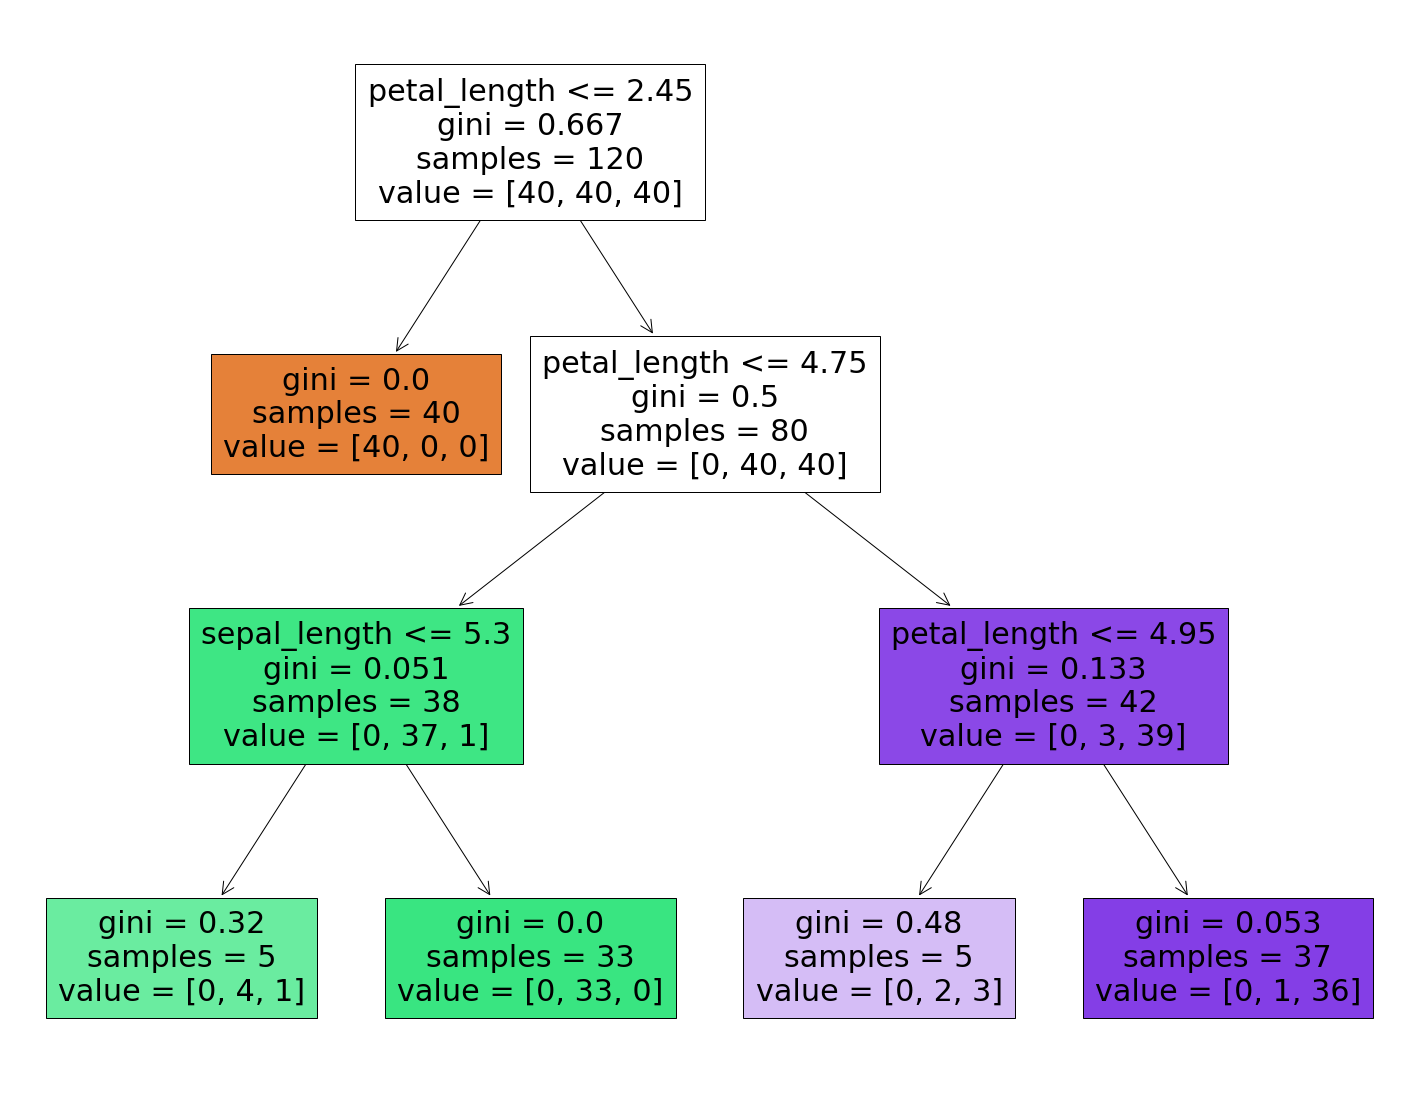

In [18]:
plt.subplots(figsize=(25, 20)) 
tree.plot_tree(DT_best, 
                   feature_names=X.columns,  
                   filled=True)
plt.show()

### summary
applied Decision Tree with cross validation to predict test dataset
* final Decision Tree Model: cretetion=gini, max_depth=3, min_samples_leaf=5
* CV f1 macro score: 0.9581
* test f1 macro score: 0.8977


The decision tree model can be intepreted intrinsically with the following creteria
* setosa creteria:     petal_length less than or equal 2.45
* versicolor creteria: petal_length between 2.45 and 4.75 
* virgihica creteria:  petal_length larger than 4.75

Decision tree model is simple and intepretable but the predictive power is less powerful. One can increase the prediction with more sophisticated models like random forest, gradient boosting or combined models with bagging.

## Random Forest
### Train Model

In [79]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}

In [80]:
RF = RandomForestClassifier(random_state=seed)
RF.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [81]:
search = GridSearchCV(estimator=RF, 
                      param_grid=param_grid,
                      scoring='f1_macro',
                        cv = 4,
                      verbose = 1)
search.fit(X_train, y_train.values.ravel())

Fitting 4 folds for each of 600 candidates, totalling 2400 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=123),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='f1_macro', verbose=1)

In [82]:
best_params = search.best_params_
print(best_params)
print('best score: ',search.best_score_)

{'max_depth': 3, 'max_features': 'auto', 'n_estimators': 5}
best score:  0.9665831244778613


In [83]:
RF_best = RandomForestClassifier(random_state=seed, **best_params)
RF_best.fit(X_train,y_train)
y_p_RF = RF_best.predict(X_test)
print(f'model f1 macro score: {RF_best.score(X_train, y_train)}')

model f1 macro score: 0.9666666666666667


/var/folders/k_/3nqdlpg11_j0bqfq9cgs15m40000gn/T/ipykernel_14602/112913382.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_best.fit(X_train,y_train)


In [84]:
evaluate_metrics(y_test, y_p_RF)

{'accuracy': 0.9333333333333333,
 'recall': 0.9333333333333332,
 'precision': 0.9333333333333332,
 'f1score': 0.9333333333333332}

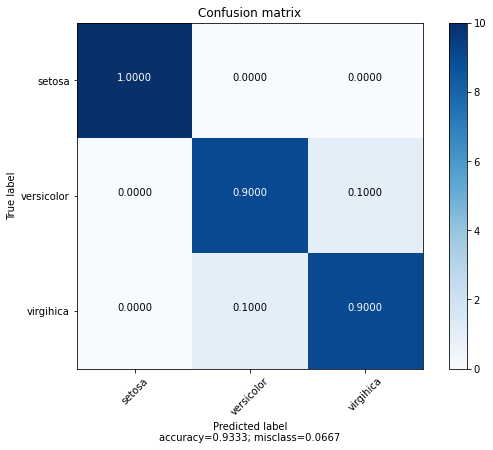

In [85]:
plot_confusion_matrix(confusion_matrix(y_test, y_p_RF),
                          ['setosa','versicolor','virgihica'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)

### Interpret Model

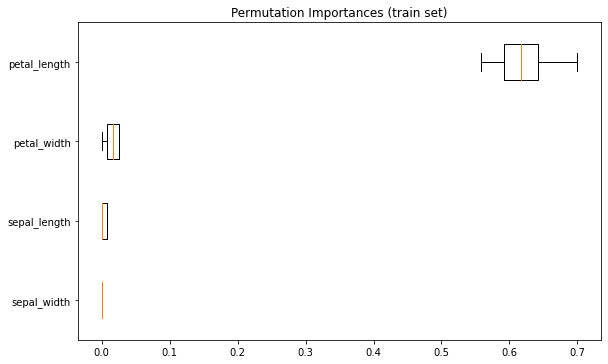

In [118]:
def visualize_feature_importance(importance_array):
    # Sort the array based on mean value
    sorted_idx = importance_array.importances_mean.argsort()
    # Visualize the feature importances using boxplot
    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(5)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    plt.show()
feature_importances = permutation_importance(estimator=RF_best, X = X_train, y = y_train, n_repeats=5,
                                random_state=123, n_jobs=2)
visualize_feature_importance(feature_importances)

/Users/johnsonchan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


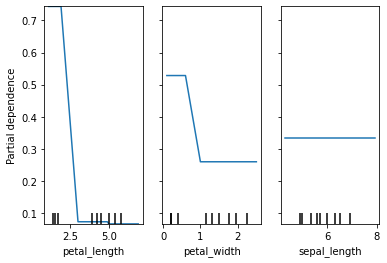

In [115]:
plot_partial_dependence(estimator=RF_best, 
                        X=X_train, 
                        target = 'setosa',
                        features=[ 'petal_length', 'petal_width','sepal_length'],
                        random_state=seed)

/Users/johnsonchan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


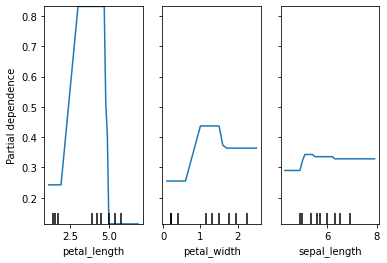

In [117]:
plot_partial_dependence(estimator=RF_best, 
                        X=X_train, 
                        target = 'versicolor',
                        features=[ 'petal_length', 'petal_width','sepal_length'],
                        random_state=seed)

/Users/johnsonchan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


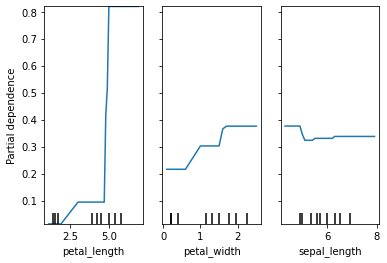

In [116]:
plot_partial_dependence(estimator=RF_best, 
                        X=X_train, 
                        target = 'virginica',
                        features=[ 'petal_length', 'petal_width','sepal_length'],
                        random_state=seed)

### summary
applied Random Forest with cross validation to predict test dataset
* final Decision Tree Model: max_depth= 3, max_features= 'auto', n_estimators=  5
* CV f1 macro score: 0.9667
* test f1 macro score: 0.9333

The random forest model cannot be intepreted intrinsically, but one can compute the permutation importances with the following order:
1. petal_length ~0.6
2. petal_width < 0.1
3. sepal_length < 0.1

and the sepal_width has almost no importance.

One can use partial dependent plot to conclude the the following creteria
* setosa creteria:     petal_length less than or equal 2.45 mostly and with petal_width less than 0.9 partly
* versicolor creteria: petal_length between 2.45 and 4.75 mostly and with petal_width larger than 0.9 partly
* virgihica creteria:  petal_length larger than 4.75 mostly and with petal_width larger than 1.5 partly

Random forest shows good predictions but difficult to explain. One can explain the exceptions to judge whether the model make sense. 

# Gradient Boost
## train model

In [69]:
model =XGBClassifier(objective='multi:softprob',random_state = seed)

In [70]:
from sklearn import preprocessing
le_species = preprocessing.LabelEncoder()
le_species.fit(['setosa','versicolor','virginica'])
y_encode_train = le_species.transform(y_train)
y_encode_test = le_species.transform(y_test)

/Users/johnsonchan/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [72]:
param_grid = {'learning_rate': [0.1*(n+1) for n in range(5)],
             'n_estimators' : [2*n+1 for n in range(5)],
              'eval_metric':['mlogloss','rmse','mae','auc']
             }

search = GridSearchCV(estimator=model, 
                      param_grid=param_grid,
                      scoring="f1_macro",
                        cv = 4,
                      verbose = 1)
search.fit(X_train, y_encode_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [74]:
best_params = search.best_params_
print(best_params)
print(search.best_score_)

{'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'n_estimators': 3}
0.9664565454039138


In [75]:
XGB_best = XGBClassifier(objective='multi:softprob',
                        random_state = seed,
                        **best_params)
XGB_best.fit(X_train,y_encode_train)
y_p_XGB = XGB_best.predict(X_test)
print(f'model f1 macro score: {XGB_best.score(X_train, y_encode_train)}')

model f1 macro score: 0.9666666666666667


In [76]:
evaluate_metrics(y_encode_test, y_p_XGB)

{'accuracy': 0.9333333333333333,
 'recall': 0.9333333333333332,
 'precision': 0.9444444444444445,
 'f1score': 0.9326599326599326}

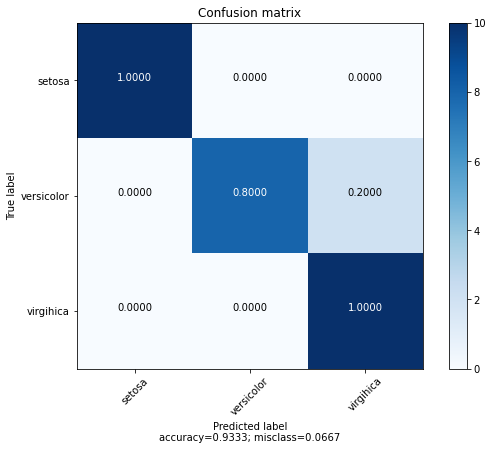

In [77]:
plot_confusion_matrix(confusion_matrix(y_encode_test, y_p_XGB),
                          ['setosa','versicolor','virgihica'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)

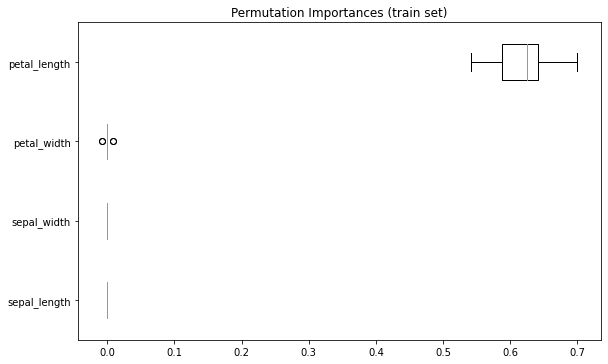

In [125]:
feature_importances = permutation_importance(estimator=XGB_best, X = X_train, y = y_encode_train, n_repeats=15,
                                random_state=123, n_jobs=4)
visualize_feature_importance(feature_importances)

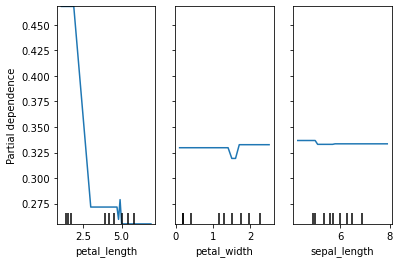

In [121]:
plot_partial_dependence(estimator=XGB_best, 
                        X=X_train, 
                        target = 0,
                        features=[ 'petal_length', 'petal_width','sepal_length'],
                        random_state=seed)

/Users/johnsonchan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


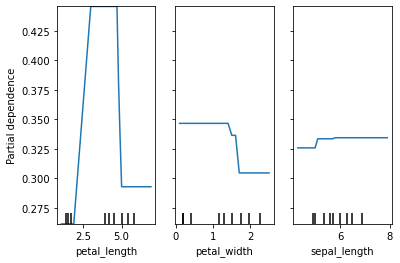

In [122]:
plot_partial_dependence(estimator=XGB_best, 
                        X=X_train, 
                        target = 1,
                        features=[ 'petal_length', 'petal_width','sepal_length'],
                        random_state=seed)

/Users/johnsonchan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


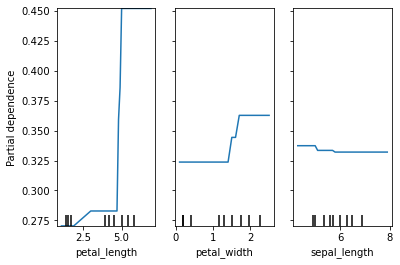

In [123]:
plot_partial_dependence(estimator=XGB_best, 
                        X=X_train, 
                        target = 2,
                        features=[ 'petal_length', 'petal_width','sepal_length'],
                        random_state=seed)

### summary
applied Random Forest with cross validation to predict test dataset
* final Decision Tree Model: eval_metric= mlogloss, learning_rate= 0.1, 'n_estimators= 3
* CV f1 macro score: 0.9667
* test f1 macro score: 0.9327

The gradient boost model cannot be intepreted intrinsically, but one can compute the permutation importances with the following order:
1. petal_length ~0.6
2. petal_width < 0.01
3. sepal_length < 0.01

The partial dependent plot to show very simular trending as that in decision tree prediction creterion but slightly overfitted judged by its variations.

Gradient boost shows similarly strong prediction power as random forest. The interpretation can be solved as well by examining exceptions. However, it seems to be slightly overfitted based on the variation in partial dependent plot. One can reduce the complexity to avoid overfitting. 


# Summary
We trained models with decision tree, random forest and gradient boost to predict iris species from iris dataset.
With F1 macro evaluation, random forest is the best predictive model among three models (with macro f1 score 0.9333), which is slightly better than gradient boost (with macro f1 score 0.9326), and much better than decision tree (with macro f1 score 0.8977)